# Exploratory Data Analysis: Multi-User Behavioural Biometrics

This notebook performs exploratory analysis on window-level behavioural features derived from typing and tapping tasks.

The objectives are to:
- characterise global feature distributions
- assess inter-individual variability
- assess intra-individual stability across sessions
- examine missingness as a behavioural signal

No predictive modelling or machine learning is performed in this notebook.

In [3]:
import glob
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [4]:
BASE = Path.cwd().parents[0]
SESSIONS_DIR = BASE / "data" / "raw" / "sessions"

AUTH_GLOB = str(SESSIONS_DIR / "*" / "auth_windows.csv")
files = sorted(glob.glob(AUTH_GLOB))

assert files, "No auth_windows.csv files found"

dfs = []
for f in files:
    df = pd.read_csv(f)
    df["sessionFolder"] = Path(f).parent.name
    dfs.append(df)

auth = pd.concat(dfs, ignore_index=True)

print("Participants:", auth["participantId"].nunique())
print("Sessions:", auth["sessionId"].nunique())
print("Windows:", len(auth))

display(auth.head())

Participants: 1
Sessions: 1
Windows: 7


,sessionId,participantId,sessionIndex,timeBucket,fatigue,inputDevice,typing_ikt_global_mean,typing_ikt_global_std,typing_ikt_global_iqr,typing_ikt_global_p95,...,tap_miss_rate_pct,tap_drift_rt,tap_error_recovery_miss_median,coupling_var_ikt,coupling_var_rt,coupling_var_ratio,windowIndex,windowStartMs,windowEndMs,sessionFolder
0,1ea8d3a866aa482f951c9734e8232bd4,p1,12,morning,4,touch,298.0,352.0,125.0,1157.0,...,0,NaN,NaN,123654.566205,NaN,NaN,0,537629,567629,1ea8d3a866aa482f951c9734e8232bd4
1,1ea8d3a866aa482f951c9734e8232bd4,p1,12,morning,4,touch,277.0,345.0,125.0,1183.0,...,0,NaN,NaN,119231.298447,NaN,NaN,1,552629,582629,1ea8d3a866aa482f951c9734e8232bd4
2,1ea8d3a866aa482f951c9734e8232bd4,p1,12,morning,4,touch,307.0,384.0,113.0,1220.0,...,0,NaN,NaN,147385.915125,NaN,NaN,2,567629,597629,1ea8d3a866aa482f951c9734e8232bd4
3,1ea8d3a866aa482f951c9734e8232bd4,p1,12,morning,4,touch,361.0,424.0,295.0,1248.0,...,5,NaN,NaN,179614.481994,92924.793651,0.517,3,582629,612629,1ea8d3a866aa482f951c9734e8232bd4
4,1ea8d3a866aa482f951c9734e8232bd4,p1,12,morning,4,touch,NaN,NaN,NaN,NaN,...,4,-73.0,NaN,NaN,54083.740247,NaN,4,597629,627629,1ea8d3a866aa482f951c9734e8232bd4


## Global Feature Distributions

We first examine the marginal distributions of timing-based behavioural features across all users and sessions.

This establishes scale, skewness, and plausibility of engineered features.

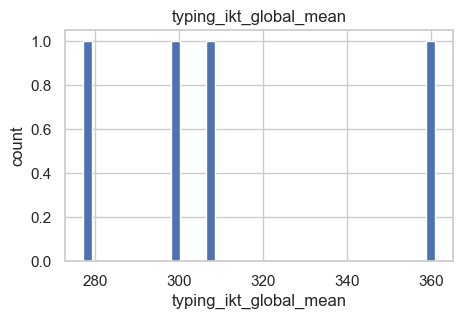

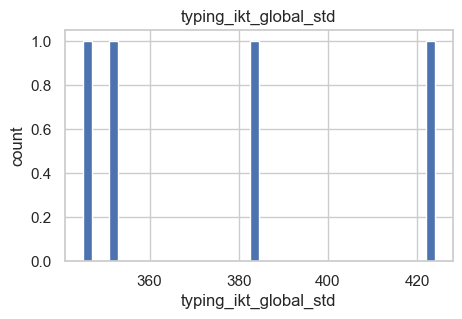

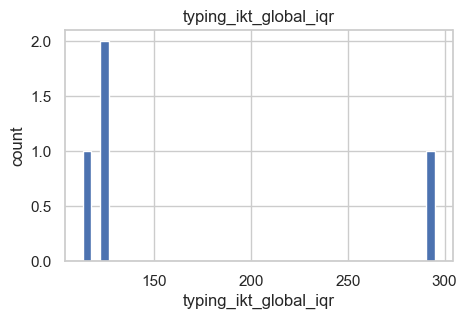

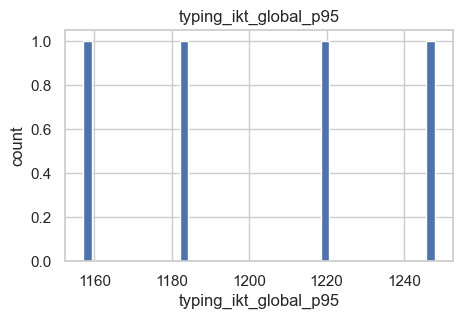

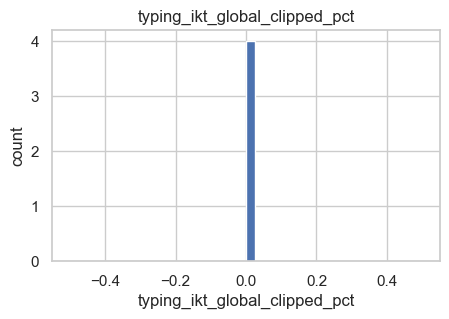

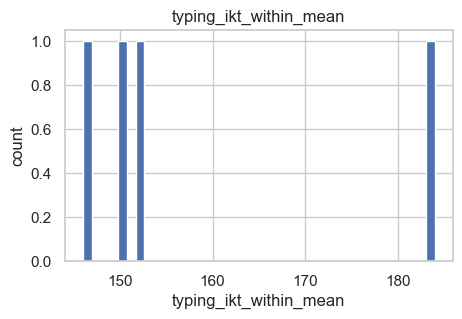

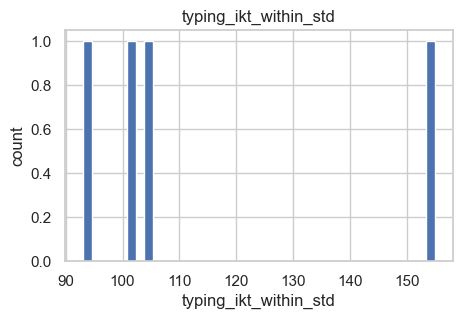

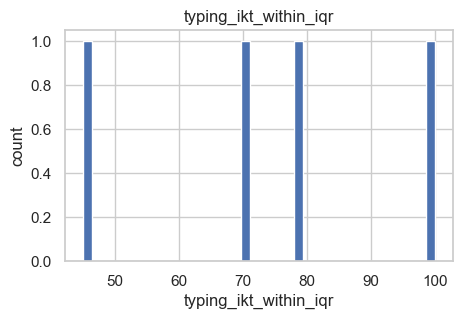

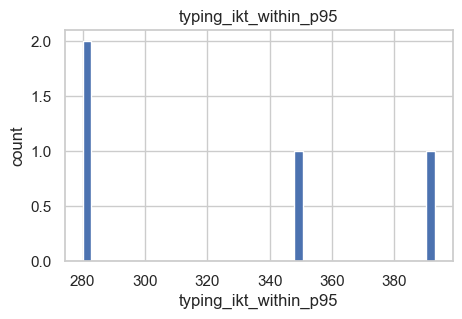

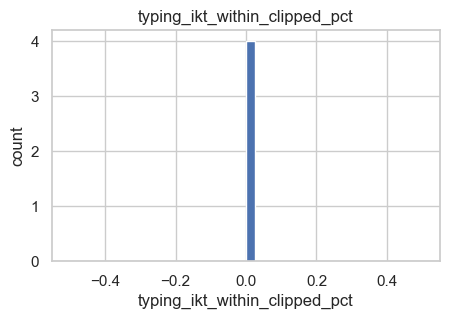

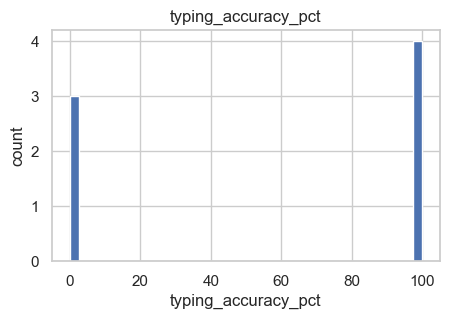

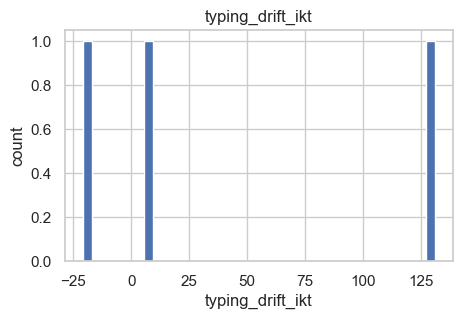

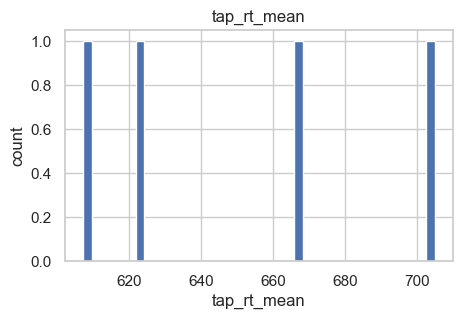

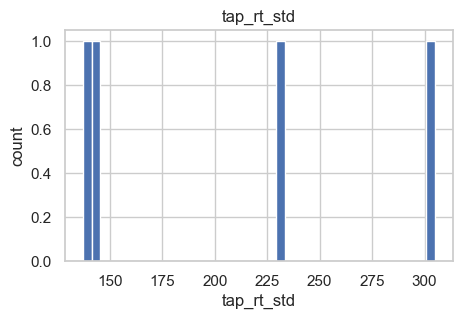

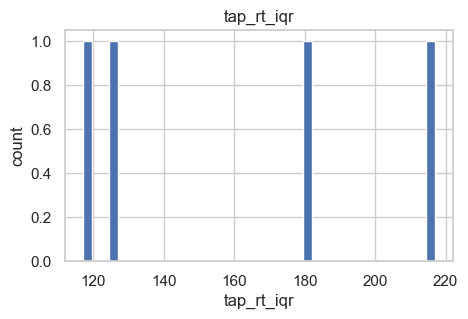

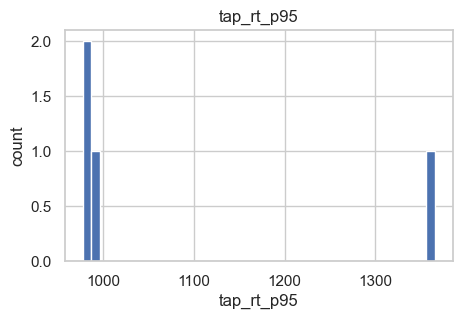

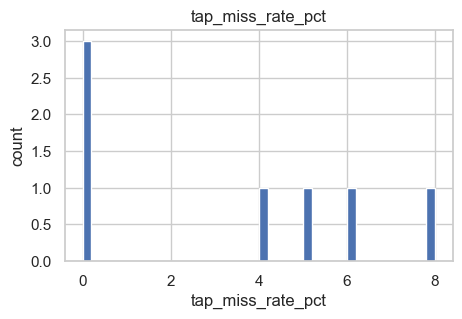

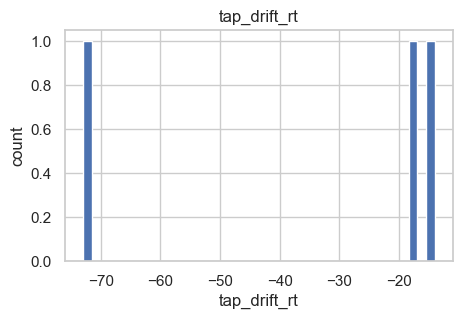

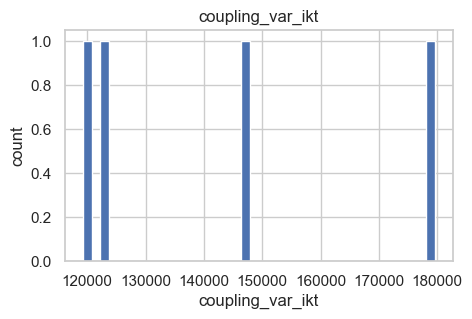

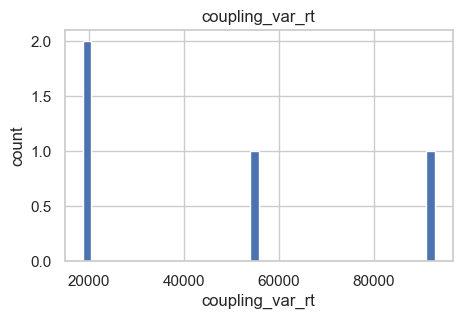

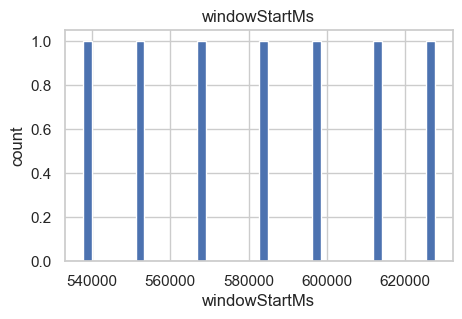

In [5]:
num_cols = auth.select_dtypes(include=[np.number]).columns

PLOT_COLS = [
    c for c in num_cols
    if any(k in c for k in ["ikt", "rt", "pct"])
]

for c in PLOT_COLS:
    data = auth[c].dropna()
    if len(data) == 0:
        continue
    plt.figure(figsize=(5,3))
    plt.hist(data, bins=40)
    plt.title(c)
    plt.xlabel(c)
    plt.ylabel("count")
    plt.show()

## Per-User Feature Distributions

We next examine whether different participants exhibit systematically different distributions for the same behavioural features.

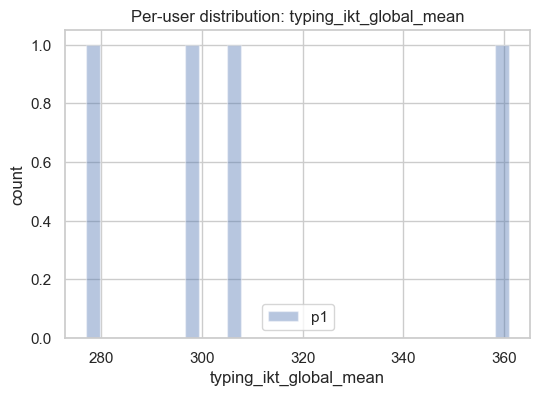

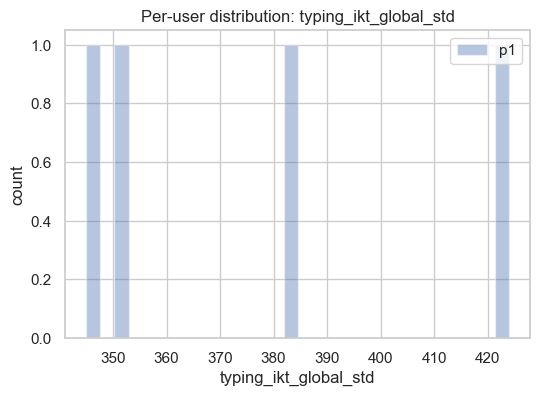

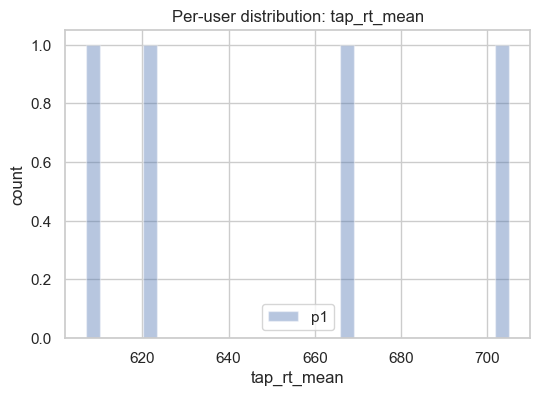

In [6]:
FEATURES_TO_COMPARE = [
    "typing_ikt_global_mean",
    "typing_ikt_global_std",
    "tap_rt_mean"
]

for feat in FEATURES_TO_COMPARE:
    if feat not in auth.columns:
        continue

    plt.figure(figsize=(6,4))
    for pid, g in auth.groupby("participantId"):
        plt.hist(g[feat].dropna(), bins=30, alpha=0.4, label=pid)

    plt.title(f"Per-user distribution: {feat}")
    plt.xlabel(feat)
    plt.ylabel("count")
    plt.legend()
    plt.show()

## Within-User vs Between-User Variability

We compare variability of behavioural features within the same participant to variability observed between different participants.

In [7]:
rows = []

for feat in FEATURES_TO_COMPARE:
    if feat not in auth.columns:
        continue

    for pid, g in auth.groupby("participantId"):
        rows.append({
            "feature": feat,
            "participantId": pid,
            "within_var": g[feat].var(),
            "mean": g[feat].mean()
        })

var_df = pd.DataFrame(rows)

display(var_df)

,feature,participantId,within_var,mean
0,typing_ikt_global_mean,p1,1280.250000,310.75
1,typing_ikt_global_std,p1,1301.583333,376.25
2,tap_rt_mean,p1,1952.916667,650.25


## Session-to-Session Stability

We examine whether behavioural features remain relatively stable for the same participant across multiple sessions.

In [8]:
session_means = (
    auth.groupby(["participantId","sessionId"])[FEATURES_TO_COMPARE]
        .mean()
        .reset_index()
)

display(session_means)

,participantId,sessionId,typing_ikt_global_mean,typing_ikt_global_std,tap_rt_mean
0,p1,1ea8d3a866aa482f951c9734e8232bd4,310.75,376.25,650.25


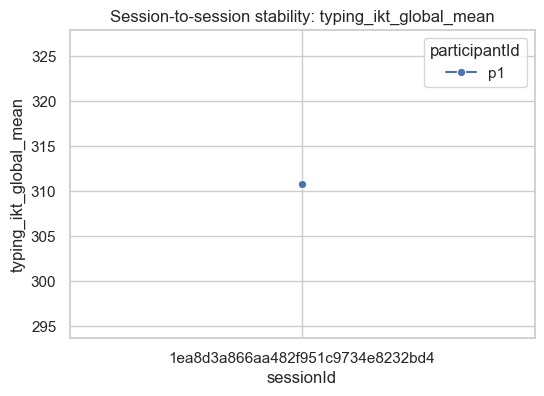

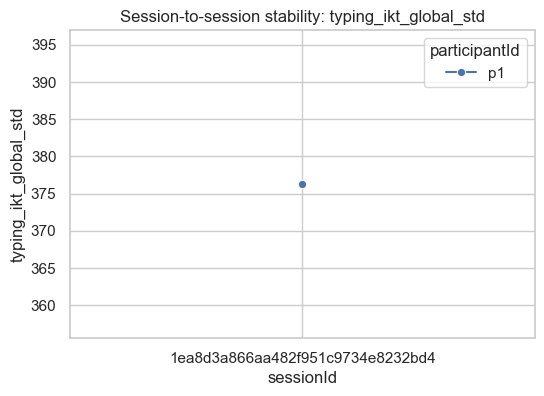

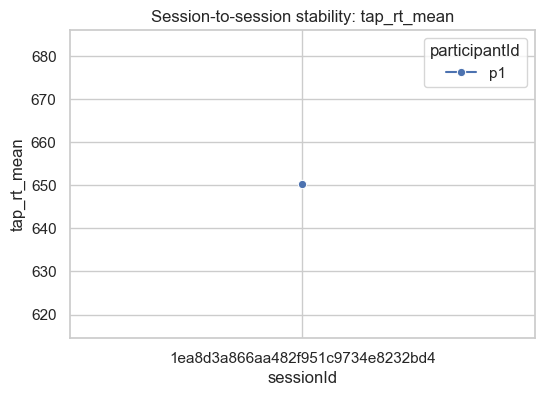

In [9]:
for feat in FEATURES_TO_COMPARE:
    plt.figure(figsize=(6,4))
    sns.lineplot(
        data=session_means,
        x="sessionId",
        y=feat,
        hue="participantId",
        marker="o"
    )
    plt.title(f"Session-to-session stability: {feat}")
    plt.show()

## Missingness Patterns

Missing values are expected for features that depend on the occurrence of specific behaviours (e.g. errors, drift). We examine missingness as an informative signal rather than a data defect.

In [10]:
num = auth.select_dtypes(include=[np.number])
miss = num.isna().mean().sort_values(ascending=False)

display(miss.head(20))

tap_error_recovery_miss_median        1.000000
typing_error_recovery_wrong_median    1.000000
coupling_var_ratio                    0.857143
typing_drift_ikt                      0.571429
tap_drift_rt                          0.571429
typing_ikt_within_std                 0.428571
typing_ikt_global_clipped_pct         0.428571
typing_ikt_within_iqr                 0.428571
typing_ikt_global_std                 0.428571
typing_ikt_global_mean                0.428571
typing_ikt_global_p95                 0.428571
typing_ikt_global_iqr                 0.428571
coupling_var_rt                       0.428571
coupling_var_ikt                      0.428571
typing_ikt_within_clipped_pct         0.428571
typing_ikt_within_p95                 0.428571
typing_ikt_within_mean                0.428571
tap_rt_p95                            0.428571
tap_rt_mean                           0.428571
tap_rt_std                            0.428571
dtype: float64

## Summary Statistics

We summarise key statistics per participant to support interpretationand downstream modelling decisions.


In [11]:
summary = (
    auth.groupby("participantId")[FEATURES_TO_COMPARE]
        .agg(["mean","std","median"])
)

display(summary)

typing_ikt_global_mean                   typing_ikt_global_std  \
                                mean        std median                  mean   
participantId                                                                  
p1                            310.75  35.780581  302.5                376.25   

                                tap_rt_mean                    
                     std median        mean        std median  
participantId                                                  
p1             36.077463  368.0      650.25  44.191817  644.5

## EDA Summary

Exploratory analysis reveals:
- substantial inter-individual variation in timing-based features
- relatively stable within-participant behaviour across sessions
- structured missingness aligned with behavioural interpretation

These observations support the hypothesis that window-level behavioural features contain identity-specific structure, motivating subsequent authentication modelling.
